<a href="https://colab.research.google.com/github/disney-snoopy/SmArtGenerative/blob/tf-notebook-edit/notebooks/style_transfer_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
import IPython.display as display

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import PIL.Image
import time
import functools

In [15]:
from tqdm import tqdm
import time

In [3]:
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

# Helper Functions (RUN)

In [10]:
def tensor_to_image(tensor):
  '''Converts output tensor back to an image'''

  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [11]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [12]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [13]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Step by step implementation

In [ ]:
content_path= '/content/drive/MyDrive/lewagon/project/img/IMG_6756.jpg'
style_path = '/content/drive/MyDrive/lewagon/project/img/main-image.jpeg'

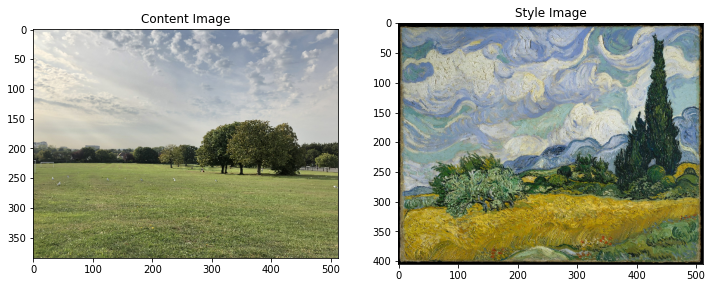

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Loading the pretrained model

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
print()
for layer in vgg.layers:
  print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Building the Model

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

### Extracting Style

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

### Model that returns style and content tensors

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.007695788
    max:  34243.633
    mean:  307.933

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  107952.98
    mean:  9889.347

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  252865.88
    mean:  7836.176

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2692064.2
    mean:  126857.25

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  176738.25
    mean:  844.1913

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1004.7295
    mean:  9.903868


### Gradient Descent 

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

NameError: ignored

In [ ]:
image = tf.Variable(content_image)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

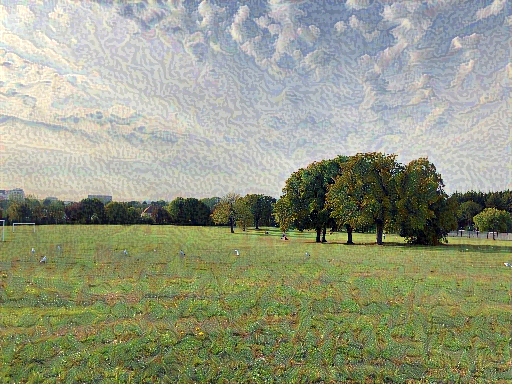

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

### Adding a Variation Loss to the function

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
image = tf.Variable(content_image)


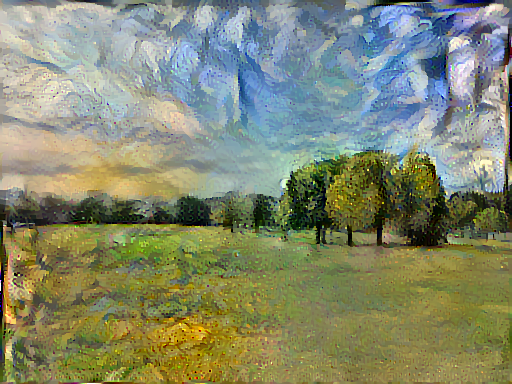

Train step: 1000
Total time: 76.4


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Combing everything into a Function

## Model

In [5]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [6]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

## Losses

In [7]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) ##MSE
                          for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) ##MSE
                            for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss

## Defining Gradient Descent Function

In [ ]:
@tf.function()
def train_step(image, extractor, loss_params, var=True, var_weight=30):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    if var:
      loss += var_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

## Style Transfer Function

In [40]:
def transfer_style(content_img_path, style_img_path, style_layers, content_layers, style_weight=1e-2, content_weight=1e4, 
                   n_epochs=10, n_steps=100, variation_loss=True, variation_weight=30):
  start = time.time()

  #Load Content
  content_image = load_img(content_path) 
  style_image = load_img(style_path)

  num_content_layers = len(content_layers)
  num_style_layers = len(style_layers)

  #Instantiate Extractor
  extractor = StyleContentModel(style_layers, content_layers)

  style_targets = extractor(style_image)['style'] #Get Style Layers
  content_targets = extractor(content_image)['content'] #Get Content Layers

  #Initialise optimizer 
  opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

  #Set loss weights
  style_weight=style_weight
  content_weight=content_weight

  #Define variable for gradient descent 
  image = tf.Variable(content_image)

  #Custom loss function for image
  def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) ##MSE
                            for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) ##MSE
                              for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


  #Function for carrying out gradient descent 
  @tf.function()
  def train_step(image, extractor, loss_params, var=True, var_weight=30):
    with tf.GradientTape() as tape:
      outputs = extractor(image)
      loss = style_content_loss(outputs)
      if var:
        loss += var_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

  #Optimization loop
  epochs = n_epochs
  steps_per_epoch = n_steps

  step = 0
  for n in tqdm(range(epochs)):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image, extractor, var=variation_loss, var_weight=variation_weight)
      print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

  end = time.time()
  print("Total time: {:.1f}".format(end-start))

  #Plotting Results 
  plt.subplot(1, 3, 1)
  imshow(content_image, 'Content Image')

  plt.subplot(1, 3, 2)
  imshow(style_image, 'Style Image')

  plt.subplot(1,3,3)
  imshow(image, 'Result')


In [11]:
content_path= '/content/drive/MyDrive/lewagon/project/img/IMG_6756.jpg'
style_path = '/content/drive/MyDrive/lewagon/project/img/VG485-1000x1000.jpg'

In [43]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

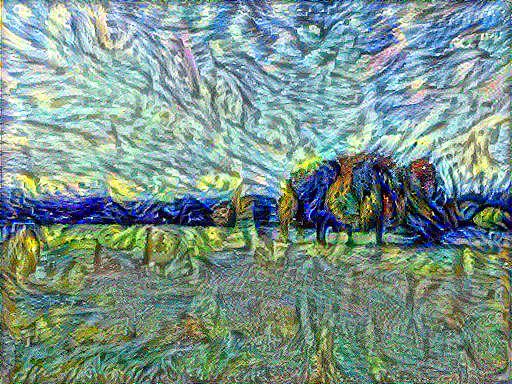

100%|██████████| 2/2 [00:14<00:00,  7.48s/it]

Train step: 200
Total time: 15.5


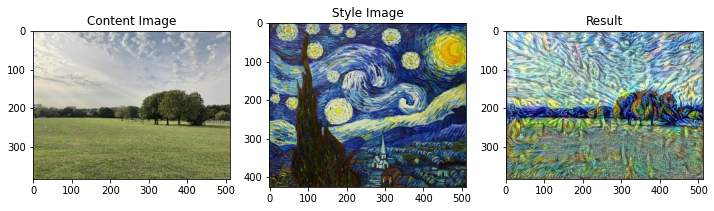

In [45]:
transfer_style(content_path, style_path, style_layers, content_layers, n_epochs=2, style_weight=1, content_weight=1e4)

In [19]:
from keras.losses import MSE

In [17]:
class Transfer():

  def __init__(self, content_img_path, style_img_path):
    #Load Content
    self.content_image = load_img(content_path) 
    self.style_image = load_img(style_path)

    self.content_layers = ['block5_conv2'] 

    self.style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

    self.num_content_layers = len(self.content_layers)
    self.num_style_layers = len(self.style_layers)

    self.extractor = StyleContentModel(self.style_layers, self.content_layers)

    self.style_targets = self.extractor(self.style_image)['style'] #Get Style Layers
    self.content_targets = self.extractor(self.content_image)['content'] #Get Content Layers

    self.var = True
    self.var_weight = 30

    self.style_weight = 1e-2
    self.content_weight = 1e4

    self.opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    self.image = tf.Variable(self.content_image)
    self.img_list = []
  

  def load_img(self, path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

  def tensor_to_image(self, tensor):
    '''Converts output tensor back to an image'''

    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

  def imshow(self, image, title=None):
    if len(image.shape) > 3:
      image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
      plt.title(title)

  def clip_0_1(self, image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

  def style_content_loss(self, outputs):
    style_outputs = self.outputs['style']
    content_outputs = self.outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-self.style_targets[name])**2) ##MSE
                            for name in style_outputs.keys()])
    style_loss *= self.style_weight / self.num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-self.content_targets[name])**2) ##MSE
                              for name in content_outputs.keys()])
    content_loss *= self.content_weight / self.num_content_layers
    loss = style_loss + content_loss
    return loss
  
  @tf.function()
  def train_step(self, image):
    with tf.GradientTape() as tape:
      self.outputs = self.extractor(image)
      loss = self.style_content_loss(self.outputs)
      if self.var:
        loss += self.var_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    self.opt.apply_gradients([(grad, image)])
    self.image.assign(clip_0_1(image))


  def transfer(self, n_epochs=4, n_steps=100, store_iter=False, show_image=True):
    epochs = n_epochs
    steps_per_epoch = n_steps

    step = 0
    for n in tqdm(range(epochs)):
      for m in range(steps_per_epoch):
        step += 1
        self.train_step(self.image)
        # print(".", end='')
      if store_iter:
        self.img_list.append(tf.convert_to_tensor(self.image))

      display.clear_output(wait=True)
      if show_image:
        display.display(tensor_to_image(self.image))
      print("Train step: {}".format(step))


  def set_weights(self,style_weight, content_weight):
    self.style_weight = style_weight
    self.content_weight = content_weight

  def set_layers(self, style_layers, content_layers):
    self.style_layers = style_layers
    self.content_layers = content_layers

    self.extractor = StyleContentModel(self.style_layers, self.content_layers)

    self.style_targets = self.extractor(self.style_image)['style'] #Get Style Layers
    self.content_targets = self.extractor(self.content_image)['content'] #Get Content Layers

  def reset_image(self):
    '''resets the stored image to content_image'''
    self.image.assign(self.content_image)


  def plot_results(self):
    plt.subplot(1, 3, 1)
    self.imshow(self.content_image, 'Content Image')

    plt.subplot(1, 3, 2)
    self.imshow(self.style_image, 'Style Image')

    plt.subplot(1,3,3)
    self.imshow(self.image, 'Result')

In [8]:
content_path = '/content/drive/MyDrive/lewagon/project/shared_images/content/trees.jpg'
style_path = '/content/drive/MyDrive/lewagon/project/shared_images/style/van-gogh-wheatfields.jpeg'

In [25]:
def param_search(content_path, style_path, n_epochs, n_comb=5, start_style_weight=1e-2, start_content_weight=1e-2,
                  stop_style_weight= 1e6, stop_content_weight=1e4, var=True, var_weight=30):
  
  style_weights = np.geomspace(start_style_weight, stop_style_weight, num=10)
  content_weights = np.geomspace(start_content_weight, stop_content_weight, num=10)

  style_weight_list = []
  content_weight_list = []

  img_list =[]

  for i in range(n_comb):
    print(f"running {i} loop")
    style_weight = np.random.choice(style_weights)
    content_weight = np.random.choice(content_weights)

    style_weight_list.append(style_weight)
    content_weight_list.append(content_weight)

    model = Transfer(content_path, style_path)

    model.set_weights(style_weight, content_weight)
    model.transfer(n_epochs=n_epochs, store_iter=True, show_image=False)
    img_list += model.img_list
    # reset_image()

  cols = ['Epoch {}'.format(col) for col in range(1, n_epochs+1)]
  rows = ['Style Weight {}\nContent Weight {}'.format(style, content) for style,content in zip(style_weight_list, content_weight_list)]

  fig, axes = plt.subplots(nrows=len(style_weight_list), ncols=n_epochs, figsize=(15, 15))

  axs = axes.flatten()
  for index,img in enumerate(img_list):
    img = tf.squeeze(img, axis=0)
    axs[index].imshow(img)
    axs[index].set_xticks([])
    axs[index].set_yticks([])

  for ax, col in zip(axes[0], cols):
      ax.set_title(col)

  for ax, row in zip(axes[:,0], rows):
      ax.set_ylabel(row, labelpad=2, rotation=0, fontsize='large')
      ax.set_label_coords(-1, 0.5)

  fig.tight_layout()
  plt.show()
  # for group in img_list:
  #   for img in group:
  #     imshow(img)
  return img_list
